### 1. Download dataset

In [49]:
PROJECT_PATH = "/Users/shawn/Documents/personal/rsi_divergence_detector"
import os
import sys
import pandas as pd
sys.path.append(f"{PROJECT_PATH}")

df = pd.read_csv(f"{PROJECT_PATH}/data/training_data.csv")
df.head(3)

,datetime,timestamp,open,high,low,close,volume,timeframe,rsi,macd,...,future_return_zscore_56,label_56,future_return_zscore_57,label_57,future_return_zscore_58,label_58,future_return_zscore_59,label_59,future_return_zscore_60,label_60
0,2017-08-17 04:33:00,1502944380000,4267.99,4267.99,4267.99,4267.99,4.127747,1m,51.955604,2.372638,...,1.314182,1,1.302888,1,1.291869,1,1.281113,1,1.270671,1
1,2017-08-17 04:34:00,1502944440000,4296.63,4296.63,4296.63,4296.63,0.952506,1m,71.973819,4.405165,...,0.580533,1,0.575438,1,0.570466,1,0.565612,1,0.560899,1
2,2017-08-17 04:35:00,1502944500000,4300.38,4300.38,4300.38,4300.38,1.038218,1m,73.529050,6.246546,...,0.485195,0,0.480906,0,0.476720,0,0.472633,0,0.468665,0


In [50]:
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce', infer_datetime_format=True)
df['datetime'] = df['datetime'].apply(lambda x: x.replace(hour=0, minute=0, second=0) if pd.notnull(x) and x.time() == pd.Timestamp.min.time() else x)

if df.index.dtype == 'int64':
    df.set_index('datetime', inplace=True)
df.head(3)


/var/folders/ns/shg9ht0545sbbr41sk4q_zgr0000gn/T/ipykernel_35141/1734794695.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce', infer_datetime_format=True)


,timestamp,open,high,low,close,volume,timeframe,rsi,macd,macd_signal,...,future_return_zscore_56,label_56,future_return_zscore_57,label_57,future_return_zscore_58,label_58,future_return_zscore_59,label_59,future_return_zscore_60,label_60
datetime,,,,,,,,,,,,,,,,,,,,,
2017-08-17 04:33:00,1502944380000,4267.99,4267.99,4267.99,4267.99,4.127747,1m,51.955604,2.372638,1.497453,...,1.314182,1,1.302888,1,1.291869,1,1.281113,1,1.270671,1
2017-08-17 04:34:00,1502944440000,4296.63,4296.63,4296.63,4296.63,0.952506,1m,71.973819,4.405165,2.078996,...,0.580533,1,0.575438,1,0.570466,1,0.565612,1,0.560899,1
2017-08-17 04:35:00,1502944500000,4300.38,4300.38,4300.38,4300.38,1.038218,1m,73.529050,6.246546,2.912506,...,0.485195,0,0.480906,0,0.476720,0,0.472633,0,0.468665,0


In [52]:
data_by_time = {}
for timeframe in df.timeframe.unique():
    data_by_time[timeframe] = df[df.timeframe == timeframe]


### 2. Feature Engineering

#### 2-1. 15min data

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [53]:
df_15 = data_by_time['15m']
df_15.head(3)

,timestamp,open,high,low,close,volume,timeframe,rsi,macd,macd_signal,...,future_return_zscore_56,label_56,future_return_zscore_57,label_57,future_return_zscore_58,label_58,future_return_zscore_59,label_59,future_return_zscore_60,label_60
datetime,,,,,,,,,,,,,,,,,,,,,
2017-08-17 12:15:00,1502972100000,4441.87,4441.87,4418.12,4418.12,9.921389,15m,55.669550,38.553087,42.856545,...,-1.160275,-1,-1.349549,-1,-1.222834,-1,-0.892135,-1,-1.379187,-1
2017-08-17 12:30:00,1502973000000,4417.00,4431.13,4411.01,4431.13,1.089877,15m,57.593369,35.966695,41.478575,...,-1.461453,-1,-1.332796,-1,-0.998939,-1,-1.487811,-1,-1.220884,-1
2017-08-17 12:45:00,1502973900000,4430.00,4431.13,4411.00,4411.00,0.846974,15m,53.709502,31.924631,39.567786,...,-1.188893,-1,-0.851731,-1,-1.348460,-1,-1.079159,-1,-0.957549,-1


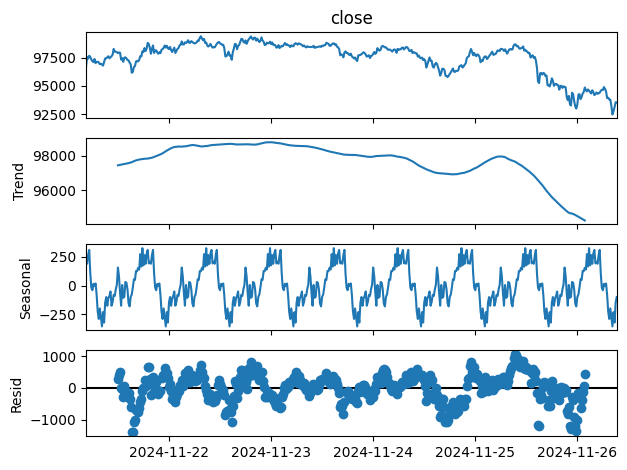

In [61]:
# use close as the final value
ts = df_15['close'][-500:]
ts = ts.dropna()

# Timeseries analysis (trend, seasonal, residual)
decomposition = seasonal_decompose(ts, model='additive', period=60)
fig = decomposition.plot()
plt.show()

In [ ]:

### Feature engineering of all
def feature_engineering(raw, target_column):
    if 'datetime' in raw.columns:
        raw['datetime'] = pd.to_datetime(raw['datetime'])
        raw['DateTime'] = pd.to_datetime(raw['datetime'])

    if raw.index.dtype == 'int64':
        raw.set_index('DateTime', inplace=True)

    raw = raw.asfreq('H', method='ffill')

    result = sm.tsa.seasonal_decompose(raw[target_column], model='additive')
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['target_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['target_seasonal']
    pd.concat([raw, Y_trend, Y_seasonal], axis=1).isnull().sum()
    if 'target_trend' not in raw.columns:
        if 'target_seasonal' not in raw.columns:
            raw = pd.concat([raw, Y_trend, Y_seasonal], axis=1)

    Y_count_Day = raw[[target_column]].rolling(24).mean()
    Y_count_Day.fillna(method='ffill', inplace=True)
    Y_count_Day.fillna(method='bfill', inplace=True)
    Y_count_Day.columns = ['count_Day']
    Y_count_Week = raw[[target_column]].rolling(24*7).mean()
    Y_count_Week.fillna(method='ffill', inplace=True)
    Y_count_Week.fillna(method='bfill', inplace=True)
    Y_count_Week.columns = ['target_Week']
    if 'target_Day' not in raw.columns:
        raw = pd.concat([raw, Y_count_Day], axis=1)
    if 'target_Week' not in raw.columns:
        raw = pd.concat([raw, Y_count_Week], axis=1)

    Y_diff = raw[[target_column]].diff()
    Y_diff.fillna(method='ffill', inplace=True)
    Y_diff.fillna(method='bfill', inplace=True)
    Y_diff.columns = ['target_diff']
    if 'target_diff' not in raw.columns:
        raw = pd.concat([raw, Y_diff], axis=1)

    raw['temp_group'] = pd.cut(raw['temp'], 10)
    raw['Year'] = raw.datetime.dt.year
    raw['Quater'] = raw.datetime.dt.quarter
    raw['Quater_ver2'] = raw['Quater'] + (raw.Year - raw.Year.min()) * 4
    raw['Month'] = raw.datetime.dt.month
    raw['Day'] = raw.datetime.dt.day
    raw['Hour'] = raw.datetime.dt.hour
    raw['DayofWeek'] = raw.datetime.dt.dayofweek

    raw['target_lag1'] = raw[target_column].shift(1)
    raw['target_lag2'] = raw[target_column].shift(2)
    raw['target_lag1'].fillna(method='bfill', inplace=True)
    raw['target_lag2'].fillna(method='bfill', inplace=True)

    if 'Quater' in raw.columns:
        if 'Quater_Dummy' not in ['_'.join(col.split('_')[:2]) for col in raw.columns]:
            raw = pd.concat([raw, pd.get_dummies(raw['Quater'], 
                                                 prefix='Quater_Dummy', drop_first=True)], axis=1)
            del raw['Quater']
    raw_fe = raw.copy()
    return raw_fe

df_15min_feature = feature_engineering(df_15)

KeyError: 'count'